# Tutorial 1: Training and Evaluation of Logistic Regression on Encrypted Data

Welcome to this first use case tutorial, where we are going to show how to use TenSEAL for training and evaluating a logistic regression (LR) model on encrypted data (using homomorphic encryption) for heart disease prediction! If you haven't played with TenSEAL before, or need a quick overview of what homomorphic encryption is, I would suggest going through ['Tutorial 0 - Getting Started'](./Tutorial%200%20-%20Getting%20Started.ipynb) first.


**Important note:** The goal of this tutorial isn't to show how efficient logistic regression is for this task, we will just go with whatever accuracy we get, but the training and evaluation on encrypted data should be comparable to when we use plain data.


Authors:
- Ayoub Benaissa - Twitter: [@y0uben11](https://twitter.com/y0uben11)

## Setup and Data

All modules are imported here. Make sure everything is installed by running the cell below:

In [12]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

We now prepare the training and test data. The dataset was downloaded from Kaggle [here](https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression). This dataset includes patients' information along with a 10-year risk of future coronary heart disease (CHD) as a label. The goal is to build a model that can predict this 10-year CHD risk based on patients' information. You can read more about the dataset in the link provided. 

Alternatively, we also provide the `random_data()` function below that generates random, linearly separable points. You can use it instead of the dataset from Kaggle, for those who just want to see how things work. The rest of the tutorial should work in the same way.

In [2]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def heart_disease_data():
    data = pd.read_csv("./data/framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop("TenYearCHD", 'columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)


def random_data(m=1024, n=2):
    # data separable by the line `y = x`
    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test


# You can use whatever data you want without modification to the tutorial
# x_train, y_train, x_test, y_test = random_data()
x_train, y_train, x_test, y_test = heart_disease_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([780, 9])
y_train has shape: torch.Size([780, 1])
x_test has shape: torch.Size([334, 9])
y_test has shape: torch.Size([334, 1])
#######################################


/tmp/ipykernel_5848/2026344545.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop("TenYearCHD", 'columns')


## Training a Logistic Regression Model

We will start by training a logistic regression model (without any encryption), which can be viewed as a single layer neural network with a single node. We will be using this model as a means of comparison against encrypted training and evaluation.

Steps:
* Make a logistic model as simply a neural network with one linear layer and a sigmoid activation function
* Train the model with `SGD` and `Binary Cross Entropy Loss` on the plaintext training dataset
* Test the model on the plaintext test dataset

In [3]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [4]:
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [5]:
# define the number of epochs for both plain and encrypted training
EPOCHS = 5

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.8504331707954407
Loss at epoch 2: 0.6863384246826172
Loss at epoch 3: 0.6358115077018738
Loss at epoch 4: 0.6193529367446899
Loss at epoch 5: 0.6124349236488342


In [6]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.703592836856842


It is worth to remember that a high accuracy isn't our goal. We just want to see that training on encrypted data doesn't affect the final result, so we will be comparing accuracies over encrypted data against the `plain_accuracy` we got here.

## Encrypted Evaluation

In this part, we will just focus on evaluating the logistic regression model with plain parameters (optionally encrypted parameters) on the encrypted test set. We first create a PyTorch-like LR model that can evaluate encrypted data:

Steps: 
* Create a model that can evaluate encrypted data, the model will get the weights from the previously trained LR model on plaintext training dataset
* Create a TenSeal context and encrypt the test dataset 
* Inference: run the model on the encrypted test dataset
* Decrypt the output, apply sigmoid on the decrypted data, calculate the accuracy, compare the accuracy when doing
evaluation on encrypted data vs on plain data.

In [7]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        

eelr = EncryptedLR(model)

We now create a TenSEALContext for specifying the scheme and the parameters we are going to use. Here we choose small and secure parameters that allow us to make a single multiplication. That's enough for evaluating a logistic regression model, however, we will see that we need larger parameters when doing training on encrypted data.

In [8]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

We will encrypt the whole test set before the evaluation:

In [9]:
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 0 seconds


In [10]:
# (optional) encrypt the model's parameters
# eelr.encrypt(ctx_eval)

As you may have already noticed when we built the EncryptedLR class, we don't compute the sigmoid function on the encrypted output of the linear layer, simply because it's not needed, and computing sigmoid over encrypted data will increase the computation time and require larger encryption parameters. However, we will use sigmoid for the encrypted training part. We now proceed with the evaluation of the encrypted test set and compare the accuracy to the one on the plain test set.

In [11]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()
    
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparaison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
    
    t_end = time()
    print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)
    

encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")

Evaluated test_set of 334 entries in 1 seconds
Accuracy: 231/334 = 0.6916167664670658
Difference between plain and encrypted accuracies: 0.011976063251495361


We saw that evaluating on the encrypted test set doesn't affect the accuracy that much. I've even seen examples where the encrypted evaluation performs better.

## Training an Encrypted Logistic Regression Model on Encrypted Data

In this part we will redefine a PyTorch-like model that can both forward encrypted data, as well as backpropagate to update the weights and thus train the encrypted logistic regression model on encrypted data. Below are more details about the training.  

Steps:
* Define a custom model that can encrypt and decrypt its parameters, can do forward/backward/params update on encrypted data, having a sigmoid approximation function
* Create a TenSealContext with proper parameters to encrypt the training dataset
* We will also plot the distributions of the output of the linear regression model on plaintext input vs on encrypted input.
* Finally we train the neural networks with encrypted parameters on encrypted input.

### Theory

#### Forward pass and Loss function

Let's derive the binary cross entropy loss function:  
First, the `sigmoid` function $\sigma(z)$ is:
$$
\begin{aligned}
  \sigma(z) &= \frac{1}{1+e^{-z}} \\
  \text{Cool property:}\quad 1-\sigma(z) &= \frac{e^{-z}}{1+e^{-z}} = \frac{1}{e^z+1} = \sigma(-z) 
\end{aligned}
$$

A predictor for $y\in\{0,1\}$ from $x$ is:
$$\hat{P}(y \mid \boldsymbol{x}, \boldsymbol{\theta}) = \frac{1}{1+e^{-\boldsymbol{\theta} \boldsymbol{x}}}$$
The likelihood function to access the model performance is:
$$L(\theta) = \prod_{i=1}^{m}\hat{P}(y^{(i)} \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}),$$
where $m$ is the number of training examples, $x^{(i)}$ is the training example $i^{th}$.  
Appy negative log for both sides:
$$
-\log (L(\theta)) = -\sum_{i=1}^{m}\log (\hat{P}(y^{(i)} \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}))
$$
Because logarithm is a strictly monotonic function, minimizing the negative log-likelihood will result in the same parameters $\theta$ as when maximizing directly the likelihood function.  

Now, because
$$
\begin{equation*}
  \hat{P}(y^{(i)} \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}) =
    \begin{cases}
      \hat{P}(1 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta})^1 &\text{if} ~ y^{(i)}=1 \\
      \hat{P}(0 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta})^{1-0} &\text{if} ~ y^{(i)}=0
    \end{cases}       
\end{equation*}
$$
we can rewrite $\hat{P}(y^{(i)} \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta})$ as 
$$
\hat{P}(y^{(i)} \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}) = \hat{P}(1\vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta})^{y^{(i)}} * \hat{P}(0 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta})^{1-y^{(i)}}
$$
Assign $\hat{P}(1 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}) = \hat{p} = \hat{y}^{(i)}$ (we only need to predict the positive class), and as we also have 
$$
\begin{aligned}
\hat{P}(0 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}) 
&= 1 - \hat{P}(1 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}) \\
\Rightarrow \hat{P}(0 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}) &= 1 - \hat{p}
\end{aligned}
$$
Therefore 
$$
\begin{aligned}
\hat{P}(y^{(i)} \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta}) &
= \hat{P}(1\vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta})^{y^{(i)}} * \hat{P}(0 \vert \boldsymbol{x^{(i)}}, \boldsymbol{\theta})^{1-y^{(i)}} \\
&= \hat{p}^{y^{(i)}} * (1-\hat{p})^{1-y^{(i)}}
\end{aligned}
$$
Inserting this into the negative log equation and normalizing by the number of examples, we can obtain the binary cross-entropy loss function
$$
\begin{aligned}
J(\theta) 
&=  -\frac{1}{m} \sum_{i=1}^{m}y^{(i)}\log \hat{p} + (1-y^{(i)})\log(1-\hat{p}) \\
&= -\frac{1}{m} \sum_{i=1}^{m}y^{(i)}\log \hat{y}^{(i)} + (1-y^{(i)})\log(1-\hat{y}^{(i)})
\end{aligned}
$$
Adding the regulazation term we will have the final loss function
$$
J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2
$$

References:  
[Binary cross-entropy and logistic regression](https://towardsdatascience.com/binary-cross-entropy-and-logistic-regression-bf7098e75559)  
[Where did the Binary Cross-Entropy Loss Function come from?](https://towardsdatascience.com/where-did-the-binary-cross-entropy-loss-function-come-from-ac3de349a715)  

#### Calculating the gradients (backward pass) and parameters update

DOING

References:  
[Deriving the sigmoid derivative via chain and quotient rules](https://hausetutorials.netlify.app/posts/2019-12-01-neural-networks-deriving-the-sigmoid-derivative/)  


#### Sigmoid approximation

Since we can't simply compute sigmoid on encrypted data (it is a non-linear function), we need to approximate it using a low degree polynomial, the lower the degree the better, as we aim to perform as few multiplications as possible, to be able to use smaller parameters and thus optimize computation. This tutorial uses a degree 3 polynomial from [https://eprint.iacr.org/2018/462.pdf](https://eprint.iacr.org/2018/462.pdf), which approximates the sigmoid function in the range $[-5,5]$.

$$\sigma(x) = 0.5 + 0.197 x - 0.004 x^3$$

#### Homomorphic Encryption Parameters

From the input data to the parameter update, a ciphertext will need a multiplicative depth of 6, 1 for the dot product operation, 2 for the sigmoid approximation, and 3 for the backprobagation phase (one is actually hidden in the `self._delta_w += enc_x * out_minus_y` operation in the `backward()` function of the neural network, which is multiplying a 1-sized vector with an n-sized one, which requires masking the first slot and replicating it n times in the first vector). With a scale of around 20 bits, we need 6 coefficients modulus with the same bit-size as the scale, plus the last coeffcient, which needs more bits, we are already out of the 4096 polynomial modulus degree (which requires < 109 total bit count of the coefficients modulus, if we consider 128-bit security), so we will use 8192. This will allow us to batch up to 4096 values in a single ciphertext, but we are far away from this limitation, so we shouldn't even think about it.

### Code

In [13]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # we use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [14]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [15]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 16 seconds


Below we study the distribution of `x.dot(weight) + bias` in both plain and encrypted domains. Making sure that it falls into the range $[-5,5]$, which is where our sigmoid approximation is good at, and we don't want to feed it data that is out of this range so that we don't get erroneous output, which can make our training behave unpredictably. But the weights will change during the training process, and we should try to keep them as small as possible while still learning. A technique often used with logistic regression, and we do exactly this (but serving another purpose which is *generalization*), is known as *regularization*, and you might already have spotted the additional term `self.weight * 0.05` in the `update_parameters()` function, which is the result of doing regularization.

To recap, since our sigmoid approximation is only good in the range $[-5,5]$, we want to have all its inputs in that range. In order to do this, we need to keep our logistic regression parameters as small as possible, so we apply regularization.

**Note:** Keeping the parameters small certainly reduces the magnitude of the output, but we can also get out of range if the data wasn't standardized. You may have spotted that we standardized the data with a mean of 0 and std of 1, this was both for better performance, as well as to keep the inputs to the sigmoid in the desired range.

Distribution on plain data:


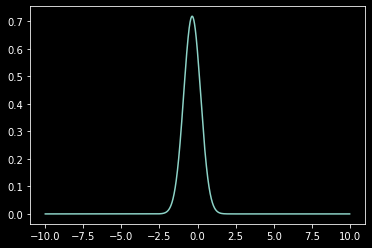

Distribution on encrypted data:


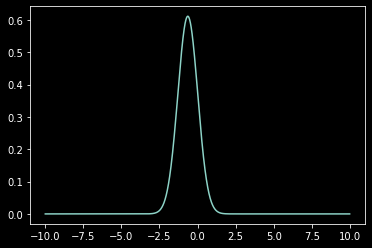

In [16]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

Most of the data falls into $[-5,5]$, the sigmoid approximation should be good enough!

We finally reached the last part, which is about training an encrypted logistic regression model on encrypted data! You can see that we decrypt the weights and re-encrypt them again after every epoch, this is necessary since after updating the weights at the end of the epoch, we can no longer use them to perform enough multiplications, so we need to get them back to the initial ciphertext level. In a real scenario, this would translate to sending the weights back to the secret-key holder for decryption and re-encryption. In that case, it will result in just a few Kilobytes of communication per epoch.

In [17]:
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.523952066898346
Accuracy at epoch #1 is 0.6766467094421387
Accuracy at epoch #2 is 0.613772451877594
Accuracy at epoch #3 is 0.6796407103538513
Accuracy at epoch #4 is 0.6197604537010193
Accuracy at epoch #5 is 0.6796407103538513

Average time per epoch: 99 seconds
Final accuracy is 0.6796407103538513
Difference between plain and encrypted accuracies: 0.023952126502990723


Even after running this cell many times myself, I always feel the joy when I see it working on encrypted data, so I hope you are feeling this joy as well!

# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement towards privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star TenSEAL on GitHub

The easiest way to help our community is just by starring the Repos! This helps raise awareness of the cool tools we're building.

- [Star TenSEAL](https://github.com/OpenMined/TenSEAL)

### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at [http://slack.openmined.org](http://slack.openmined.org). #lib_tenseal and #code_tenseal are the main channels for the TenSEAL project.

### Join our Team!

If you're excited about what we are working on TenSEAL, and if you're interested to work on homomorphic encryption related use cases, you should definitely join us!

[Apply to the crypto team!](https://docs.google.com/forms/d/1T6MJ21V1lb7aEr4ilZOTYQXzxXP6KbpLumZVmTZMSuY/edit)


### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)
